# Réseaux de neurones LSTM appliqué à la prédiction du turfu de NeoCampus


https://icml.cc/Conferences/2002/craft.html
Petit résumé :
 - Describe the representation and organization of the system's knowledge, along with the representation of training data : un graphique du model (keras.utils.plot_model), un head All.csv, un head neolite.csv, un plot
 - Evaluate the approach to learning, avoiding unsubstantiated or rhetorical claims. If stating that one approach is better than others, include evidence or at least careful arguments to support these claims.
 - Experiments that systematically vary external resources, such as the number of training cases available for learning, can also contribute important insights into an algorithm's behavior : plot la perf sur le dev set en fonction de $|train set|$
 - Make sure you label all distinct components of each figure : label des axes, unité s'il y en a une, label des plots, légende et titre
 

 
## Résumé

Nous appliquons un réseau de neurones avec couche LSTM à la prédiction des valeurs futures des capteurs disséminés dans quelques salles du campus de l'UPS, à partir de séries temporelles des valeurs de ces mêmes capteurs. La bibliothèque keras (tensorflow backend) est utilisée.

## Introduction

Dans le cadre du M1 DC, nous avons accès aux données des salles équipées de capteurs NeoCampus, 

## Données


### Prétraitement

#### Données brutes

Des capteurs de quatre types (co2, luminosité, humidité et température) sont disposés sur six ilots. Nous disposons des valeurs enregistrées à intervalles variables (entre une seconde et une minute selon le capteur).

|type|room|value|date|unit|ilot|
|---|---|---|---|---|---|
|temperature|u4/302/temperature/ilot1|22.93|2017-09-11T12:53:14.745366|celsius|ilot1|
|temperature|u4/302/temperature/ilot2|24.16|2017-09-11T12:53:14.767362|celsius|ilot2|
|co2|u4/302/co2/ilot1|357|2017-09-11T12:53:14.794131|ppm|ilot1|
|temperature|u4/302/temperature/ilot3|24.36|2017-09-11T12:53:14.797038|celsius|ilot3|
|co2|u4/302/co2/ilot2|361|2017-09-11T12:53:14.818348|ppm|ilot2|

*Table 1 : Données brutes*

#### Prétraitement - phase 1

Les valeurs sont sélectionnées par type (ici la luminosité), agrégées par moyenne sur un interval donné (ici 15 minutes), et associées à leur valeur de confort

|timestamp|lum|confort|
|---|---|---|
|1254272|839.35|5|
|1254273|867.5833333333334|5|
|1254274|791.0666666666667|5|
|1254275|466.53333333333336|2|
|1254276|698.5932203389831|5|

*Table 2 : Luminosité de l'ilot1, moyenne sur 15 minutes*

#### Prétraitement - phase 2

Les valeurs sont regroupées en séries temporelles, puis normalisées.
Soient :

  - $v_i$ la valeur d'un capteur d'un type donné à l'instant $i$
  - $w$ la taille de la fenêtre
  - $k$ l'avance (on prédit $k$ instants après)

Nous formons un vecteur $(v_1, v_2, ..., v_w)$ que nous étiquetons avec la valeur moyenne de la $k$-ième prochaine fenêtre $\sum_{i=1}^{k}{v_{w k+i}} \over w$ :

| $v_1$ | $v_1$ | $v_1$ | $v_1$ | $\sum_{i=1}^{k}{v_{w k+i}} / w$ |
|---|---|---|---|---|
|361.11666666666673|351.8|334.31666666666666|237.56666666666663|235.1125|
|236.4|234.11864406779662|236.0|233.36666666666667|256.45296610169487|
|234.55|237.38333333333333|234.5|234.01666666666668|737.2541666666667|
|234.16666666666663|235.51666666666668|237.41666666666663|318.7118644067797|378.575|
|827.5166666666668|1219.5333333333333|531.4166666666666|370.55|351.275|

*Table 3 : Fenêtre temporelle de 4 valeurs, prédiction à i+8*


**Après interpolation, on perd la relation de moyenne**


| $v_1$ | $v_1$ | $v_1$ | $v_1$ | $\sum_{i=1}^{k}{v_{w k+i}} / w$ |
|---|---|---|---|---|
|0.13202776|0.12696186|0.11745537|0.06484798|0.09021222322482127|
|0.06421361|0.06297313|0.06399611|0.06256424|0.10701879027823007|
|0.06320768|0.06474829|0.06318049|0.06291768|0.4856711392076145|
|0.06299924|0.0637333|0.06476641|0.10897033|0.20319532839271504|
|0.38563077|0.59878815|0.22462766|0.13715709|0.18169536309806658|

*Table 4 : Fenêtre temporelle de 4 valeurs normalisées, prédiction à i+8*


**Après interpolation inverse, on ne la retrouve pas !**


| $v_1$ | $v_1$ | $v_1$ | $v_1$ | $\sum_{i=1}^{k}{v_{w k+i}} / w$ |
|---|---|---|---|---|
|288.20859275|281.77607043|269.70502228|202.905752|235.1125|
|202.10024831|200.52512778|201.82407562|200.00593872|256.45296610169487|
|200.82294961|202.77917285|200.78842802|200.45471935|737.2541666666667|
|200.55828411|201.49036695|202.80218724|258.93097159|378.575|
|610.22595354|880.88670051|405.78911707|294.72166544|351.2749999999999|

*Table 5 : Fenêtre temporelle de 4 valeurs dé-normalisées, prédiction à i+8*


**C'est donc un problème, non ?**


  


Données brutes, prétraitement, visualisations/exploration

### Visualisations

#### Distributions
<img src="images/distribution_time.png">
La présence de longues périodes sans données recueillies (ou très peu) demandera d'être prise en compte lors de la création des séries temporelles, sans quoi certaines n'auront pas le nombre requis de mesures.

<img src="images/distributions_sensors.png">
Ici, on peut observer la distribution des différentes colonnes des données : certains capteurs ont une large plage de valeurs possibles  distribuées de manière relativement uniforme (humidité, température), d'autres sont disposées sur des modes avec quelques occurences des valeurs non modales (co2, luminosité).
On observe que le confort ne descend que très rarement en dessous de 2 : soit la fonction de confort est mal paramétrée, soit les conditions environnementales des salles ne sont jamais horribles (la seconde hypothèse semble plus probable).

#### Corrélations

<img src="images/correlations_heatmap.png">
Cette matrice présente la corrélation entre chaque capteur. On y observe le fonctionnement de la fonction de confort : le principal facteur est la température, suivie de la luminosité, puis de l'humidité et du co2. On remarque de relativement fortes corrélations entre luminosité et température (le soleil serait-il le facteur commun ?), et entre co2 et température/luminosité (le fait que les humains sont diurnes serait-il le facteur commun ?). L'humidité ne semble pas corrélée à quoi que ce soit de manière notable : peut-être pourrait on la retirer sans trop de pertes de performances.
On déduit de cette matrice que l'on obtiendra de biens meilleures prédictions avec tous les capteurs qu'avec un seul. (EST-CE RAISONNABLE COMME DEDUCTION ??)


<img src="images/autocorrelation_lum.png">
On remarque très bien la présence d'un cycle de 24h dans l'autocorrélation du capteur de luminosité. Cela permet de confirmer que les valeurs des capteurs dépendent du moment de la journée, et sont prédictibles à partir des valeurs antérieures (pas complétement, sinon on aurait une autocorrélation de 1). Cette autocorrélation diminue avec l'augmentation du délai, à cause de l'influence de paramètres externes (il est possible que demain soit plus nuageux qu'hier...).
La luminosité présente l'autocorrélation la plus forte, mais tous les capteurs sont un minimum autocorrélés (sur des multiples de 24h).

#### k-means

<img src="images/kmeans_co2.png">
L'algorithme de clustering k-means peut également être appliquée sur des séries temporelles. Les clusters seront les séries "moyennes/types" du jeu de données.
Les lignes rouges représentent les clusters et les lignes noires (ou tâches noires en fond) les observations assignées au cluster. L'opacité des observations assignées montrent leur nombre.

<img src="images/kmeans_confort.png">
On voit bien que les périodes de changement (clusters 1 et 2) sont moins fréquentes que les périodes stables (cluster 3). Il est important de prendre cette répartition en compte afin de ne pas obtenir un modèle prédisant des séries stables (qui pourrait se voir attribuer une bonne performance selon la métrique dûe à leur forte proportion dans les données).

#### Décomposition saisonale
<img src="images/decomposition_seasonal_temp.png">
Il est possible de décomposer une série temporelle. Nous avons utilisé une décomposition saisonale naïve (statsmodels.api.tsa.seasonal_decompose()) qui permet d'obtenir les composantes "trend" (tendance), "seasonal" (saisonale/périodique) et "residual" (résidus). En combinant ces deux composantes, on obtient la courbe d'origine, aux résidus près (plus il y a de résidus, moins la décomposition permet de reproduire la série originel : la série est bruitée (ou notre modèle inadaptée..)).

<img src="images/decomposition_predictions_temp.png">
Ce graphique présente le modèle obtenu par décomposition sur une période appliquée à cette même période (en vert), puis aux restes des données (en rouge). On voit très bien que le comportement de la courbe n'est pas le même du tout entre ces deux périodes. Il est nécessaire de prendre en compte ces différences dans la distribution des cibles lors de l'entraînement d'un modèle (sinon on a un modèle qui prédit très bien la semaine 38 de l'année 2017, mais rien d'autre).
Ici, le modèle se trompe complètement, mais pour certains capteurs (luminosité notament), la composante saisonale reste la même quelque soit la période de l'année.



## Modèle

Description du modèle, pourquoi (ou le pourquoi sera dans l'intro ?), processus d'entrainement

## Résultats

Nous effectuons plusieurs tests pour estimer notre modèle, en le comparant avec la régression linéaire classique de scikit-learn.

On teste sur les données de l'ilot1, pour chaque type de capteur (pas les mêmes allures de courbes), pour les configurations suivantes : 

 - Fenêtre de taille 2, prédiction de la fenêtre suivante
 - Fenêtre de taille 16, prédiction de la 4ème fenêtre suivante
 - Fenêtre de taille 32, prédiction de la 16ème fenêtre suivante

Lorsqu'on prédit loin dans l'avenir, aucune prédiction intermédiaire n'a été prévue.

On a mesuré plusieurs métriques

 - Mean absolute error et mean squared error : ça montre l'écart entre les prévisions et la réalité. La seconde pénalise les très mauvaises prédictions. C'est une mesure de régression, faite sur la valeur prédite du capteur.
 - Accuracy f-measure jaccard : les trois donnent exactement le même résultat, je ne sais pas pourquoi :-( C'est une métrique de classification calculée sur le score de confort, recalculé depuis la valeur prédite du capteur.
 - Distance au sens de la DTW : non calculée car *très très* long. 

D'une façon générale, les résultats sont très proches entre le modèle super-balèze long à entraîner et la régression qui prend moins d'une seconde. Même si le modèle s'avère *un tout petit peu* meilleur.

Mesures de MAE, MSE et Accuracy pour les différentes combinaisons de test : les mêmes erreurs sur les mêmes tests !


| Mean average error | Mean squared error | Accuracy |
|---|---|---|
| 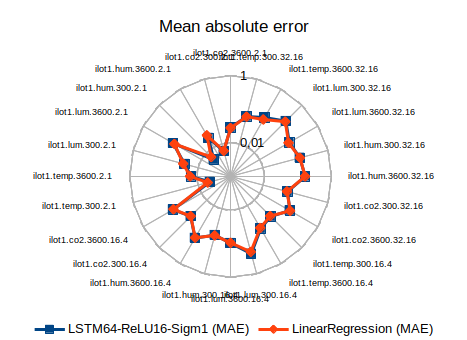 | 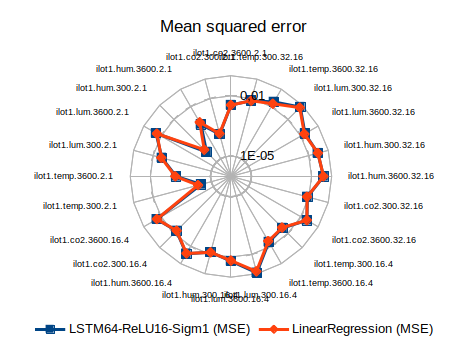 | 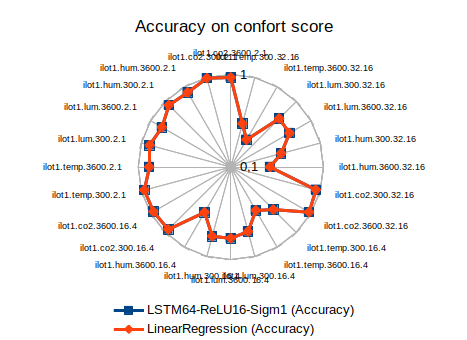 |



Par ailleurs j'ai reservé quelques dizaines de points pour la visualisation de prédiction alignées. Je ne sais pas si c'est très utile ici, mais moi ça m'a bien parlé : c'est facilement interprétable comme on dit.

|Jeu de test|MSE|Précision|Visualisation LSTM64-ReLU16-Sigm1|Visualisation régression linéaire|
|---|---|---|---|---|
|ilot1.temp.300.2.1| Faible 0.005 | Élevée 0.93 | 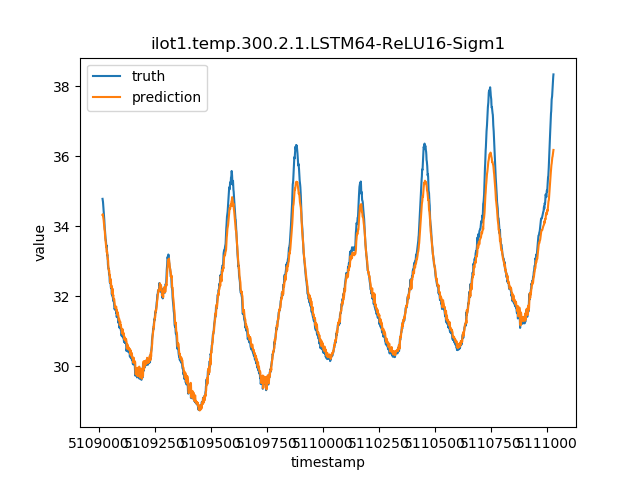 | 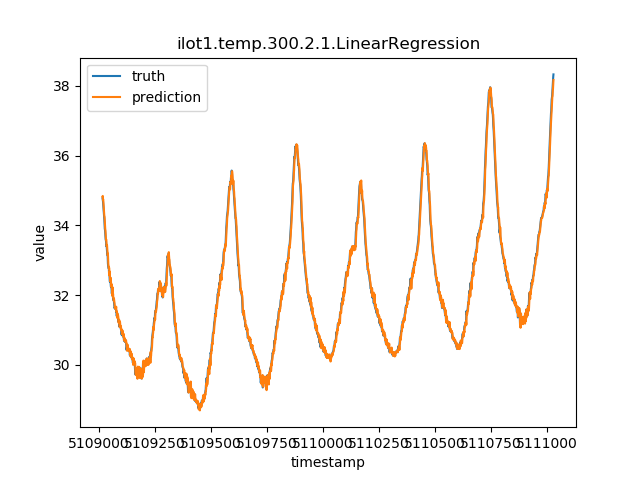 |
|ilot1.co2.3600.16.4 | Élevée 0.09 | Élevée 0.92 | 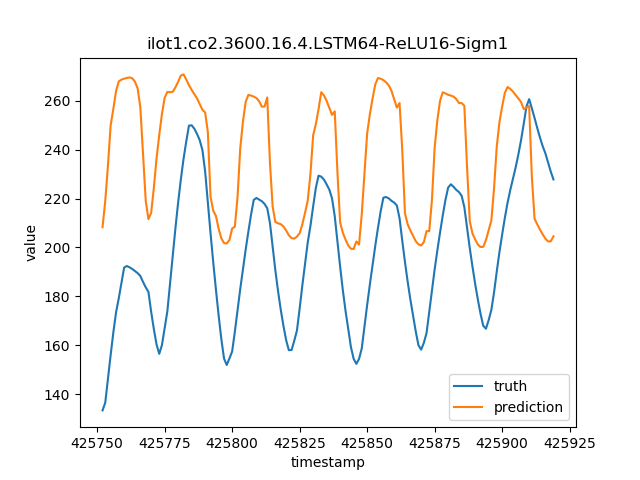 | 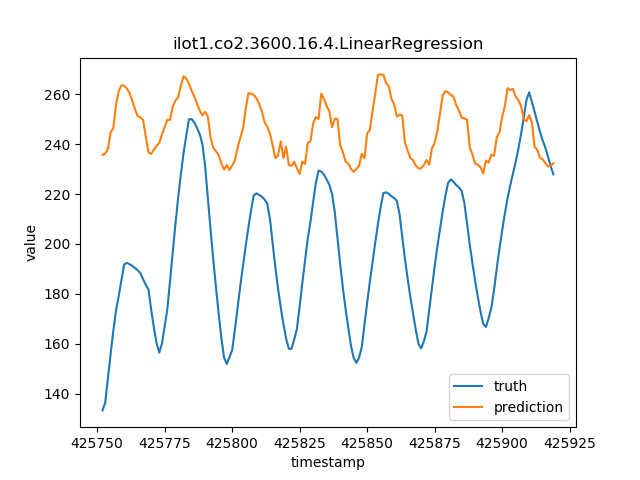 |
|ilot1.temp.3600.32.16| Élevée 0.1 | Faible 0.22 | 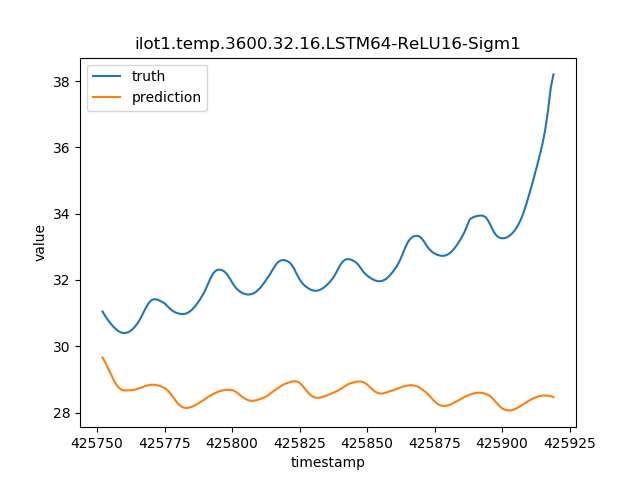 | 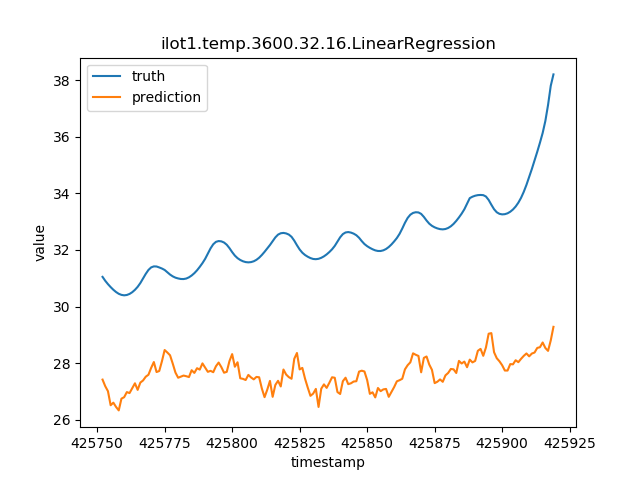 |

Donc finalement on peut conclure que : 

 - Le modèle fait quelque chose de très comparable à la régression linéaire
 - La MSE et la MAE mesurent la même chose, mais diffèrent de la précision. En effet, on discrétise avec la fonction de confort, qui n'est pas homogène : les erreurs ne sont pas toutes atténuées de la même façon.
 - Le modèle, comme la régression, sont efficaces sur les prédictions à un quart d'heure, mais moins sur les prédictions à une heure. Encore moins sur celles à 4, et à 16. C'est parce qu'ils ont tendance à prédire en retard, et que ce retard est moins grave sur 15 minutes. On pourrait vérifier cette théorie en prédisant sur un intervalle qui matche avec la saisonnalité des données (24 heures).
 
 

métriques et méthodes d'évaluation, plots des prédictions, recette du kebab vegan, description des résultats (la mse monte quand x, on a trouvé un optimal, ça marche bien à x point)

## Analyse

Des explications plus fines que ce qui est directement visible dans les résultats : ça marche bien parce que..., ça marche mal parce que 

Ce qu'on va essayer la prochaine fois (ou alors dans la conclusion si c'est court ?)

## Conclusion

Nous avons fait X, ça a donné Y mais aussi Z